Initialize h2o and import the dataset

In [1]:
import h2o
h2o.init()
import matplotlib.pyplot as plt
%matplotlib inline

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.11" 2021-04-20; OpenJDK Runtime Environment (build 11.0.11+9-Ubuntu-0ubuntu2.20.04); OpenJDK 64-Bit Server VM (build 11.0.11+9-Ubuntu-0ubuntu2.20.04, mixed mode, sharing)
  Starting server from /home/gerd/Documents/Python/venvs/h2o/lib/python3.8/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmp8p1laamm
  JVM stdout: /tmp/tmp8p1laamm/h2o_gerd_started_from_python.out
  JVM stderr: /tmp/tmp8p1laamm/h2o_gerd_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Vienna
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.32.1.2
H2O_cluster_version_age:,1 month and 28 days
H2O_cluster_name:,H2O_from_python_gerd_452ere
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,2.867 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"accepting new members, healthy"


In [2]:
data= h2o.import_file("http://coursera.h2o.ai/cacao.882.csv")

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [3]:
#data.summary()
#data.nlevels()

In [4]:
##split data into train, valid and test datasets 
train,valid,test = data.split_frame([.8,.1], seed=69)
##validate the size of dataset (uncommnt to execute)
#print( "%d %d %d" % (train.nrows,valid.nrows, test.nrows  ))

In [5]:
## set the features and response column names, the column Origin
## was removed because of its high cardinality and its redundancy (bean origin),
## the reduced model resulted in a lower error and deviance
## 
y =  'Rating'

xAll = [i for i in train.names if i not in y]
xAll2 =[i for i in train.names if i not in ['Rating', 'Origin']]


In [6]:
## build a deep learning model with default parameters with full reduced feature list(a regression model to predict "Rating")
## run_time 12s

from h2o.estimators.deeplearning import H2ODeepLearningEstimator
m_def = H2ODeepLearningEstimator(model_id = "untuned_model", seed = 69)
%time m_def.train(xAll, y, train, validation_frame = valid)

deeplearning Model Build progress: |██████████████████████████████████████| 100%
CPU times: user 152 ms, sys: 18.1 ms, total: 171 ms
Wall time: 5.61 s


In [7]:
m_def.model_performance(test)


ModelMetricsRegression: deeplearning
** Reported on test data. **

MSE: 0.19681962167075714
RMSE: 0.4436435750360385
MAE: 0.3603727703925595
RMSLE: 0.11013162418652048
Mean Residual Deviance: 0.19681962167075714


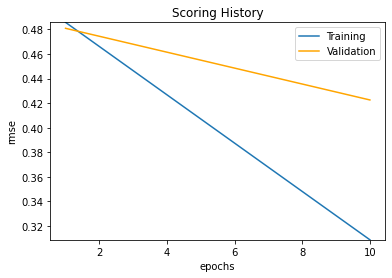

In [8]:
m_def.plot()

In [9]:
## tuned model initalization and training
## for the tuned model the origin feature was deopped because of high cardinality and its redundancy (bean origin)
## run_time 35s
m_def_tuned =H2ODeepLearningEstimator(epochs =25,
                                   stopping_rounds =5,
                                   stopping_tolerance = 0,
                                   stopping_metric = "AUTO",
                                    l1 = 1e-6,
                                    l2 = 1e-6,
                                    hidden = [400,400],
                                    hidden_dropout_ratios = [0.1,0.1],
                                    activation ="RectifierWithDropout",
                                    model_id = "tuned_model", seed = 69)
%time m_def_tuned.train(xAll2, y, train, validation_frame = valid)

deeplearning Model Build progress: |██████████████████████████████████████| 100%
CPU times: user 322 ms, sys: 4.36 ms, total: 327 ms
Wall time: 19 s


In [10]:
m_def_tuned.model_performance(test)


ModelMetricsRegression: deeplearning
** Reported on test data. **

MSE: 0.20071413708411115
RMSE: 0.4480113135670919
MAE: 0.3597250752109869
RMSLE: 0.11177230882043533
Mean Residual Deviance: 0.20071413708411115


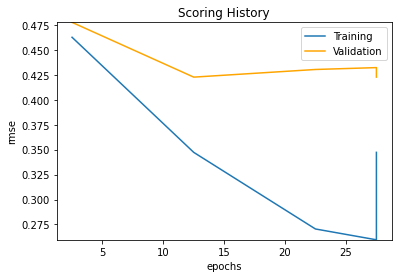

In [11]:
m_def_tuned.plot()

In [ ]:
##save models
h2o.save_model(m_def, "c:\h2o_models")
h2o.save_model(m_def_tuned, "c:\h2o_models")

In [12]:
h2o.cluster().shutdown()

H2O session _sid_9f70 closed.
